In [ ]:
# Tester rapidement les imports dans un notebook ou script Python :
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling
import sweetviz
import dtale
import autoviz
# import dataprep
# import pandasgui

print("Tout est prêt pour ton analyse ! 🚀")


# Import des données

https://www.kaggle.com/datasets/gspmoreira/news-portal-user-interactions-by-globocom#clicks_sample.csv

# Structure des fichiers

## Articles
Les articles possèdent également des métadonnées explicites.
L'outil de prévisualisation de kaggle nous permet déjà de supprimer publisher_id qui est O pour l'ensemble des articles.<br>
Il y a aussi des articles vides (0 mot)<br>
Les catégories sont nombreuses (461)<br>
Les timestamp sont en notation UNIX: comptage de millisecondes depuis 1/1/1970 transformable en date par <br>
<code> date = datetime.utcfromtimestamp(timestamp_s) </code>

In [1]:
import pandas as pd
df_articles = pd.read_csv("./data/articles_metadata.csv", encoding='utf-8')
df_articles

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


In [2]:
# Importation
from ydata_profiling import ProfileReport
import ipywidgets as widgets
widgets.IntSlider()


# Génération du rapport sur le dataframe "articles"
profile = ProfileReport(df_articles, title="Profiling DataFrame Articles")

# Affichage du rapport directement dans JupyterLab
profile.to_notebook_iframe()


ModuleNotFoundError: No module named 'ydata_profiling'

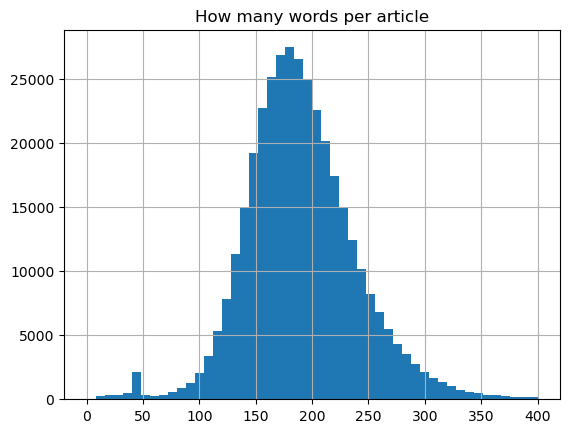

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df_articles.words_count.hist(bins=50, range=(0,400))
plt.title('How many words per article');

## Embeddings
Créés avec CHAMELEON. Les 364047 articles et leurs métadonnées sont modélisés dans 250 dimensions vectorielles.<br>
Logiquement l'index est l'id de l'article.

In [4]:
import pickle

# Charger le fichier pickle
with open('./data/articles_embeddings.pickle', 'rb') as f:
    data = pickle.load(f)


In [5]:
import pandas as pd

# Exemple si data est un dictionnaire :
embeddings = pd.DataFrame(data)
embeddings.shape

(364047, 250)

In [6]:
embeddings.head()


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


### Visualisation des embeddings

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import umap.umap_ as umap

# Échantillonnage
sampled_embeddings = embeddings.sample(5000, random_state=42)

# Paramètres à tester
configs = [
    {"title": "n_neighbors=15, min_dist=0.1 (défaut)", "params": {"n_neighbors":15, "min_dist":0.1, "metric":"euclidean"}},
    {"title": "n_neighbors=30, min_dist=0.3, metric=cosine", "params": {"n_neighbors":30, "min_dist":0.3, "metric":"cosine"}},
    {"title": "n_neighbors=30, min_dist=0.2, metric=cosine", "params": {"n_neighbors":30, "min_dist":0.2, "metric":"cosine", "spread":1.5}}
]

plt.figure(figsize=(15, 5))

for i, config in enumerate(configs):
    reducer = umap.UMAP(random_state=42, **config["params"])
    umap_results = reducer.fit_transform(sampled_embeddings)
    
    plt.subplot(1, 3, i + 1)
    plt.scatter(umap_results[:, 0], umap_results[:, 1], s=2, alpha=0.5)
    plt.title(config["title"])
    plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'umap'

Il y a quelques groupes qui se dessinent, c'est confus il faut essayer de faire des regroupements

### Regroupement par clusters

In [8]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Paramètres
n_samples = 10000
cluster_counts = [15, 25, 35]

# Échantillonnage
sampled_embeddings = embeddings.sample(n=n_samples, random_state=42)
sampled_array = sampled_embeddings.to_numpy()
sampled_index = sampled_embeddings.index  # pour les tooltips si besoin

# Normalisation
scaler = StandardScaler()
sampled_scaled = scaler.fit_transform(sampled_array)

# UMAP en 3D
reducer = umap.UMAP(n_components=3, random_state=42, metric="cosine", n_neighbors=30, min_dist=0.3, spread=1.5)
embedding_3d = reducer.fit_transform(sampled_scaled)

# Base DataFrame
df_visu = pd.DataFrame(embedding_3d, columns=["x", "y", "z"])
df_visu["index"] = sampled_index

# Clusterisations et traces
traces = []
buttons = []

for i, n_clusters in enumerate(cluster_counts):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(sampled_scaled)

    df_visu[f'cluster_{n_clusters}'] = cluster_labels

    trace = go.Scatter3d(
        x=df_visu['x'],
        y=df_visu['y'],
        z=df_visu['z'],
        mode='markers',
        marker=dict(
            size=3,
            color=df_visu[f'cluster_{n_clusters}'],
            colorscale='Turbo',        # 🌈 Palette bien contrastée
            colorbar=dict(             # ✅ Échelle des couleurs
                title=f'Clusters ({n_clusters})',
                len=0.75
            ),
            opacity=0.7
        ),
        name=f'{n_clusters} clusters',
        visible=(i == 0),
        text=[f"Index: {idx}" for idx in df_visu["index"]],
        hoverinfo="text"
    )
    traces.append(trace)

    # Bouton dropdown
    buttons.append(dict(
        label=f"{n_clusters} clusters",
        method="update",
        args=[
            {"visible": [j == i for j in range(len(cluster_counts))]},
            {"title": f"Clustering avec {n_clusters} clusters"}
        ]
    ))

# Création de la figure
fig = go.Figure(data=traces)

# Menu déroulant
fig.update_layout(
    title="Clustering interactif UMAP 3D",
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )],
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(
        xaxis=dict(title='UMAP-1'),
        yaxis=dict(title='UMAP-2'),
        zaxis=dict(title='UMAP-3')
    )
)

fig.show()


ModuleNotFoundError: No module named 'plotly'

La distance cosine semble bien séparer les embeddings. On pourra se servir de cette sur-catégorisation pour enrichir le dataframe articles.

In [9]:
import gc
gc.collect()

6663

### Réduction des dimensions par PCA

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Étape 1 : Standardiser les embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Étape 2 : Appliquer PCA avec n_components="mle" pour déterminer automatiquement
pca = PCA(n_components=0.90, svd_solver='full')  # 0.90 = au moins 90% de variance
embeddings_pca = pca.fit_transform(embeddings_scaled)
embeddings_pca_df = pd.DataFrame(embeddings_pca)

# Résultat
print(f"✅ PCA terminée. Nombre de dimensions retenues : {embeddings_pca.shape[1]}")


✅ PCA terminée. Nombre de dimensions retenues : 41


In [11]:
import pandas as pd
import os

# Création du dossier s'il n'existe pas
os.makedirs('./data', exist_ok=True)

# Assurons-nous que l'index est bien article_id (optionnel si déjà fait)
embeddings_pca_df.index.name = 'article_id'

# Sauvegarde au format Parquet
embeddings_pca_df.to_parquet('./data/articles_embeddings_pca.parquet')

print("✅ Embeddings PCA sauvegardés dans ./data/articles_embeddings_pca.parquet")

✅ Embeddings PCA sauvegardés dans ./data/articles_embeddings_pca.parquet


In [ ]:
# Calcule l'empreinte mémoire de chaque DataFrame
original_memory = embeddings.memory_usage(deep=True).sum()
reduced_memory = embeddings_pca_df.memory_usage(deep=True).sum()

# Calcule le gain absolu et relatif
memory_saved = original_memory - reduced_memory
memory_gain_percent = (memory_saved / original_memory) * 100

# Affiche les résultats en Mo
print(f"Mémoire utilisée avant PCA : {original_memory / (1024 ** 2):.2f} Mo")
print(f"Mémoire utilisée après PCA : {reduced_memory / (1024 ** 2):.2f} Mo")
print(f"Gain de mémoire : {memory_saved / (1024 ** 2):.2f} Mo ({memory_gain_percent:.2f}%)")


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

pca_full = PCA().fit(embeddings_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance, marker='.')
plt.axhline(y=0.9, color='r', linestyle='--', label="90% variance")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance cumulée")
plt.title("Variance capturée par PCA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
%matplotlib inline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 🔹 Étape 6 : Clustering KMeans
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(umap_results)

# 🔹 Étape 7 : Visualisation colorée par cluster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    umap_results[:, 0], umap_results[:, 1],
    c=clusters, cmap='turbo', s=5, alpha=0.7
)
plt.title("UMAP 2D avec KMeans (20 clusters, ech. 5000)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.colorbar(scatter, label="Cluster ID")
plt.show()


Les embeddings sont toujours clairement séparables, ils sont à priori une bonne représentation des articles.

### Enrichissement du dataframe d'articles avec les méta-catégories

In [5]:
import pandas as pd
import numpy as np
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Chargement des données (à adapter si déjà en mémoire)
# df_articles = pd.read_csv("path/to/articles.csv")  # par exemple
# embeddings = pd.read_csv("path/to/embeddings.csv")  # ou un np.array

# Vérification : embeddings doit avoir la même longueur que df_articles
assert len(df_articles) == len(embeddings), "Le nombre de lignes ne correspond pas entre df_articles et embeddings"

# Étape 1 : Réduction de dimension avec UMAP
umap_model = umap.UMAP(n_components=2, random_state=42, metric="cosine", n_neighbors=30, min_dist=0.3, spread=1.5)
embeddings_2d = umap_model.fit_transform(embeddings)

# Étape 2 : Clustering avec KMeans (20 clusters)
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(embeddings_2d)

# Étape 3 : Ajout des clusters au DataFrame original
df_articles["cluster"] = clusters

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [6]:
import gc
gc.collect()

40794

In [ ]:
import seaborn as sns

# Étape 4 : Créer un DataFrame avec les coordonnées UMAP + cluster
df_umap = pd.DataFrame(embeddings_2d, columns=["umap_x", "umap_y"])
df_umap["cluster"] = clusters

# Échantillonnage pour affichage rapide
sample = df_umap.sample(n=1000, random_state=42) if len(df_umap) > 1000 else df_umap

# Visualisation avec seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sample,
    x="umap_x",
    y="umap_y",
    hue="cluster",
    palette="tab20",
    legend="full",
    s=30
)
plt.title("Projection UMAP et clustering KMeans sur un échantillon")
plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Enregistrement des clicks lors des sessions
On dispose des clicks (un fichier par heure) effectués par les utilisateurs sur une période de deux semaines du site globo.com <br>
Les colonnes concernent: l'identification de la session et ses caractéristiques, les articles concernés, l'environnement de l'utilisateur (appareil, OS, pays, origine de navigation, région)<br>
Pour un session_id et un user_id il y session_size (nombre d'interactions lors de la session) lignes avec un click_article_id pour chaque interaction.<br>
click_environment: contexte du click (Facebook, App mobile, web)

In [13]:
clicks_sample = pd.read_csv("./data/clicks_sample.csv", encoding='utf-8')
clicks_sample.head(20)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
5,2,1506825435299739,1506825435000,2,30970,1506827120575,4,1,17,1,24,2
6,3,1506825442704740,1506825442000,2,236065,1506827536942,4,3,2,1,21,1
7,3,1506825442704740,1506825442000,2,236294,1506827566942,4,3,2,1,21,1
8,4,1506825528135741,1506825528000,2,48915,1506826927593,4,1,17,1,17,1
9,4,1506825528135741,1506825528000,2,44488,1506826957593,4,1,17,1,17,1


On dispose de 305 fichiers de clicks clicks_hour_000.csv à clicks_hour_304.csv dans le dossier cliks.

In [14]:
import pandas as pd
import glob

file_paths = sorted(glob.glob('./data/clicks/clicks_hour_*.csv'))

def load_click_file(path):
    return pd.read_csv(path, dtype={
        'user_id': 'int32', # 'str' évite que Pandas interprète des IDs numériques longs comme des floats
        'session_id': 'int64',
        'session_start': 'int64',           # 🔥 ne laisse pas de place à l'interprétation !
        'session_size': 'int16',
        'click_article_id': 'int32',
        'click_timestamp': 'int64',         # 🔥 aussi important
        'click_environment': 'category',
        'click_deviceGroup': 'category',
        'click_os': 'category',
        'click_country': 'category',
        'click_region': 'category',
        'click_referrer_type': 'category',
    })

df_clicks = pd.concat((load_click_file(f) for f in file_paths), ignore_index=True)



In [15]:
df_clicks.shape

(2988181, 12)

In [ ]:
# Calcule l'empreinte mémoire du dataframe de tous les clics
df_clicks_memory = df_clicks.memory_usage(deep=True).sum()

# Affiche les résultats en Go
print(f"Mémoire utilisée par le dataframe de clics : {df_clicks_memory / (1024 ** 3):.4f} Go")


In [ ]:
# # Passage au sdk car ydata ne supporte pas des data aussi lourdes (les int64, même castés en timestamp)
# from ydata.sdk.dataset import Dataset
# from ydata.sdk.quality import evaluate_quality

# # Créer un objet Dataset
# dataset = Dataset(df_clicks)

# # Lancer une évaluation qualité complète
# report = evaluate_quality(dataset)

# # Visualiser les résultats
# report.summary()


In [ ]:
from ydata_profiling import ProfileReport
import pandas as pd

def make_profiling_sample(df, sample_size=50000, random_state=42):
    """
    Génère un rapport YData Profiling sur un échantillon du DataFrame.
    
    - Si sample_size=None ou <= 0, le profiling se fait sur l'ensemble du DataFrame.
    - Les colonnes temporelles 'session_start' et 'click_timestamp' (au format int64) sont converties en datetime.
    - De nouvelles colonnes sont ajoutées :
        - 'session_start_dt' : datetime de début de session
        - 'click_timestamp_dt' : datetime du clic
        - 'click_hour' : heure du clic (0-23)
        - 'click_day' : jour de la semaine du clic (0 = lundi, 6 = dimanche)
    
    Retourne :
        DataFrame enrichi pour l’analyse temporelle et la visualisation.
    """
    
    if sample_size is None or sample_size <= 0:
        df_sample = df.copy()
    else:
        df_sample = df.sample(sample_size, random_state=random_state).copy()

    # Colonnes datetime
    df_sample['session_start_dt'] = pd.to_datetime(df_sample['session_start'], unit='ms')
    df_sample['click_timestamp_dt'] = pd.to_datetime(df_sample['click_timestamp'], unit='ms')

    # Extraction de composants temporels
    df_sample['click_hour'] = df_sample['click_timestamp_dt'].dt.hour
    df_sample['click_day'] = df_sample['click_timestamp_dt'].dt.dayofweek  # 0 = lundi, 6 = dimanche

    # Profiling
    profile = ProfileReport(
        df_sample.drop(columns=['session_start', 'click_timestamp']),
        title="Profil YData - Clicks",
        minimal=True,
        explorative=True
    )

    profile.to_notebook_iframe()

    return df_sample



In [ ]:
df_profiling = make_profiling_sample(df_clicks, sample_size=10000)

In [ ]:
# Utiliser un ensemble pour stocker les user_id uniques
unique_user_ids = set()

# Parcourir et traiter chaque fichier
for file in file_paths:
    df = pd.read_csv(file, usecols=['user_id'])
    unique_user_ids.update(df['user_id'].unique())

# Comptabiliser les user_id uniques
num_unique_user_ids = len(unique_user_ids)

print(f"Nombre total d'user_id uniques : {num_unique_user_ids}")


### Fit article_id (df_articles) et click_article_id (df_clicks)

In [11]:
# Vérification: tous les id d'articles sont bien dans le dataframe articles (sous article_id)
# Identifier les articles cliqués non présents dans le catalogue
missing_articles = df_clicks.loc[~df_clicks['click_article_id'].isin(df_articles['article_id'])]

# Nombre et aperçu
print(f"Nombre d'articles cliqués absents du catalogue : {missing_articles['click_article_id'].nunique()}")
print(missing_articles['click_article_id'].value_counts().head())


Nombre d'articles cliqués absents du catalogue : 0
Series([], Name: count, dtype: int64)


📰 Nombre total d'articles : 364047
🕳️  Nombre d'articles jamais cliqués : 318014
📉  Pourcentage jamais cliqués : 87.36%


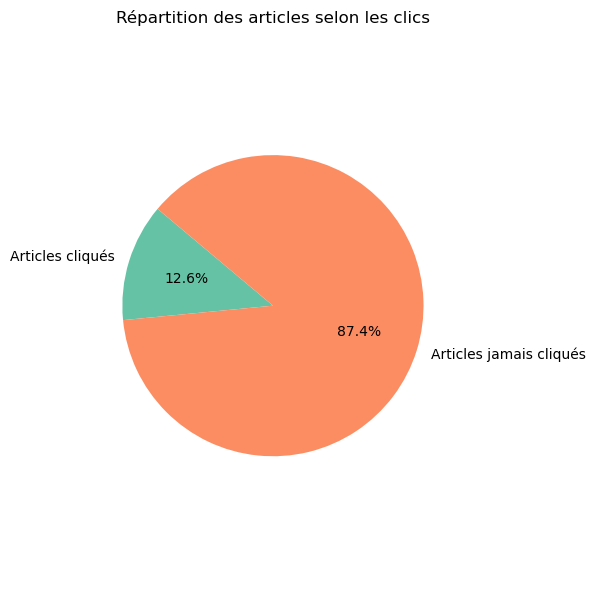

In [12]:
import matplotlib.pyplot as plt

# Articles jamais cliqués
unused_articles = df_articles.loc[~df_articles['article_id'].isin(df_clicks['click_article_id'])]

# Totaux
total_articles = df_articles['article_id'].nunique()
unused_count = unused_articles['article_id'].nunique()
used_count = total_articles - unused_count
unused_percent = (unused_count / total_articles) * 100

# Résumé texte
print(f"📰 Nombre total d'articles : {total_articles}")
print(f"🕳️  Nombre d'articles jamais cliqués : {unused_count}")
print(f"📉  Pourcentage jamais cliqués : {unused_percent:.2f}%")

# Données pour le camembert
labels = ['Articles cliqués', 'Articles jamais cliqués']
sizes = [used_count, unused_count]
colors = ['#66c2a5', '#fc8d62']

# Camembert
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Répartition des articles selon les clics")
plt.axis('equal')
plt.tight_layout()
plt.show()


On a un problème de cold start sur les articles: un grand nombre d'articles non cliqués. Ils seront exclus du calcul des modèles collaboratifs qui s'appuient sur les interactions passées. Par contre l'approche content-based (sur les métadonnées) sera meilleure.

In [13]:
# Dernier clic enregistré
last_click_date = pd.to_datetime(df_clicks['click_timestamp'].max(), unit='ms')

# Dernière date de publication d'article
last_article_date = pd.to_datetime(df_articles['created_at_ts'].max(), unit='ms')

# Affichage
print(f"🕑 Dernier clic enregistré : {last_click_date}")
print(f"📰 Dernier article publié : {last_article_date}")


🕑 Dernier clic enregistré : 2017-11-13 20:04:14.886000
📰 Dernier article publié : 2018-03-13 12:12:30


<b> Les datasets sont désynchronisés:<br></b>
-  Le dataset df_clicks couvre une période de temps limitée (15 jours).
-  Le dataset df_articles contient un catalogue complet y compris des articles publiés après la période d’observation

In [14]:
# Conversion de la date de publication
df_articles['publish_time_dt'] = pd.to_datetime(df_articles['created_at_ts'], unit='ms')

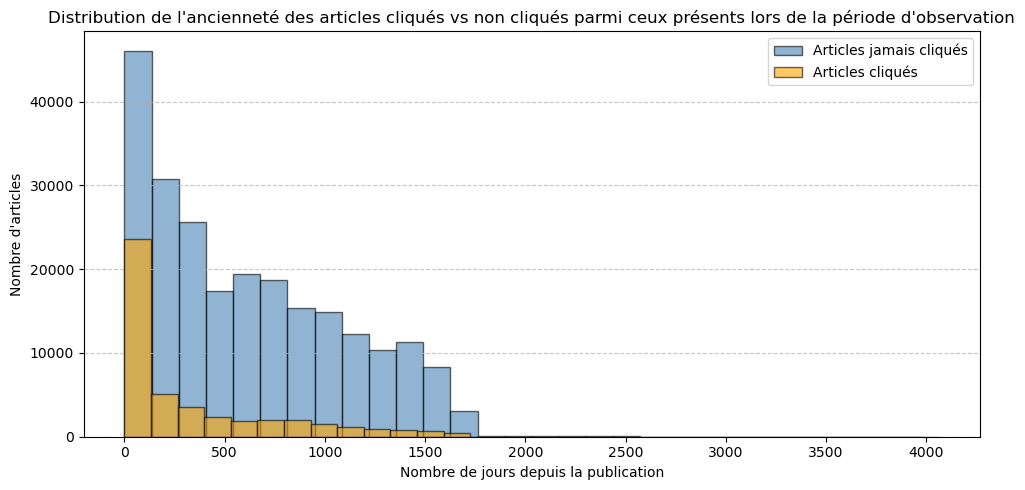

In [15]:
# Récupération du timestamp du dernier clic observé
max_click_time = pd.to_datetime(df_clicks['click_timestamp'].max(), unit='ms')

# Filtrer les articles publiés après la période d'observation
df_articles_valid = df_articles[df_articles['publish_time_dt'] <= max_click_time]

# Séparation des articles valides cliqués vs non cliqués
unused_articles = df_articles_valid.loc[~df_articles_valid['article_id'].isin(df_clicks['click_article_id'])].copy()
used_articles = df_articles_valid.loc[df_articles_valid['article_id'].isin(df_clicks['click_article_id'])].copy()

# Calcul de l'ancienneté en jours
unused_articles['days_since_pub'] = (max_click_time - unused_articles['publish_time_dt']).dt.days
used_articles['days_since_pub'] = (max_click_time - used_articles['publish_time_dt']).dt.days

# 📊 Affichage de la distribution comparée
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(unused_articles['days_since_pub'], bins=30, alpha=0.6, label='Articles jamais cliqués', color='steelblue', edgecolor='black')
plt.hist(used_articles['days_since_pub'], bins=30, alpha=0.6, label='Articles cliqués', color='orange', edgecolor='black')
plt.title("Distribution de l'ancienneté des articles cliqués vs non cliqués parmi ceux présents lors de la période d'observation")
plt.xlabel("Nombre de jours depuis la publication")
plt.ylabel("Nombre d'articles")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

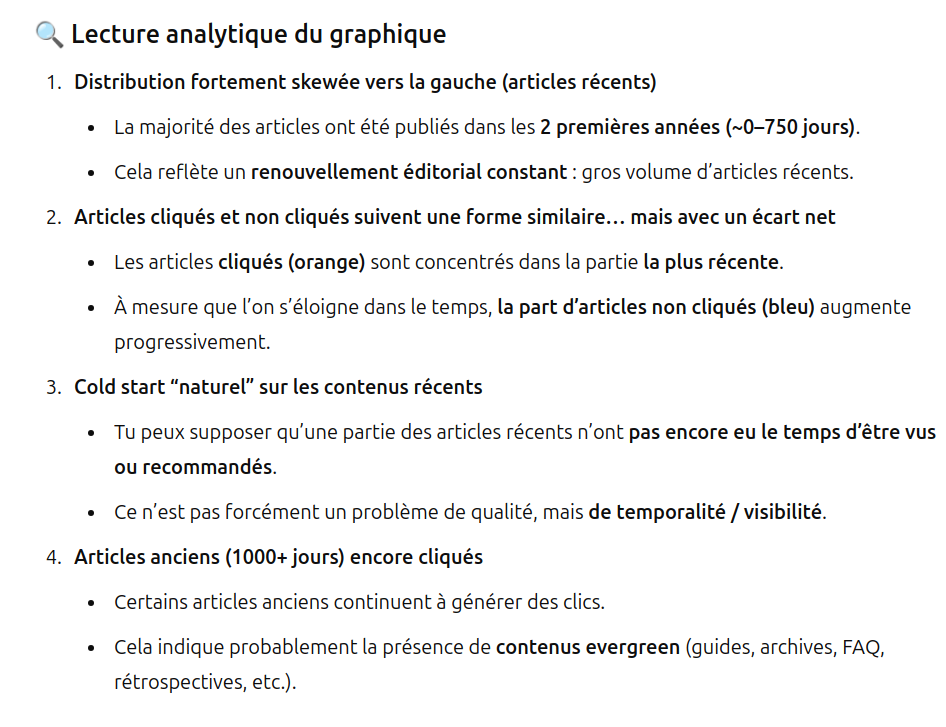

L'information date de clic vs date de publication sera disponible en combinant par merge les métadonnées des articles dans df_clicks sur article_id

### Cohérence entre le clic et la date de publication

In [16]:
# Jointure : clics enrichis avec la date de création des articles
df_merged = df_clicks.merge(
    df_articles[['article_id', 'created_at_ts']],
    left_on='click_article_id',
    right_on='article_id',
    how='left'
)

# Vérifie si le clic est postérieur ou égal à la création de l'article
df_merged['click_after_creation'] = df_merged['click_timestamp'] >= df_merged['created_at_ts']

# Statistiques
coherence_rate = df_merged['click_after_creation'].mean()
nb_incoherents = (~df_merged['click_after_creation']).sum()

print(f"Taux de clics effectués après création de l'article : {coherence_rate:.2%}")
print(f"Nombre de clics incohérents (avant création de l'article) : {nb_incoherents}")


Taux de clics effectués après création de l'article : 99.88%
Nombre de clics incohérents (avant création de l'article) : 3613


### Cohérence entre le moment du clic et le début de la session

In [17]:
# Vérifie que le clic est postérieur ou égal au début de la session
df_clicks['click_after_session_start'] = df_clicks['click_timestamp'] >= df_clicks['session_start']

# Statistiques de cohérence
session_coherence_rate = df_clicks['click_after_session_start'].mean()
nb_incoherents_session = (~df_clicks['click_after_session_start']).sum()

print(f"Taux de clics cohérents avec le début de session : {session_coherence_rate:.2%}")
print(f"Nombre de clics incohérents (avant le début de session) : {nb_incoherents_session}")

Taux de clics cohérents avec le début de session : 100.00%
Nombre de clics incohérents (avant le début de session) : 0


In [18]:
df_clicks.drop(columns=['click_after_session_start'], inplace=True)

L'enregistrement des temps semble cohérent dans df_clicks et il y a quelques incohérences avec df_articles. Donc si on utilise un marqueur temporel ça sera celui du clic (le plus précis et le plus fiable)

### Articles vides

In [19]:
# Étape 1 : Filtrer les articles publiés avant le dernier clic
max_click_time = pd.to_datetime(df_clicks['click_timestamp'].max(), unit='ms')
df_articles['publish_time_dt'] = pd.to_datetime(df_articles['created_at_ts'], unit='ms')
df_articles_valid = df_articles[df_articles['publish_time_dt'] <= max_click_time]

# Étape 2 : Isoler les articles vides
empty_articles = df_articles_valid[df_articles_valid['words_count'] == 0]

# Étape 3 : Vérifier combien ont été cliqués
clicked_empty_articles = empty_articles[empty_articles['article_id'].isin(df_clicks['click_article_id'])]

# Résumé
print(f"🕳️ Articles sans contenu (words_count = 0) publiés avant la fin de la période : {len(empty_articles)}")
print(f"🖱️ Parmi eux, cliqués au moins une fois : {len(clicked_empty_articles)}")

# Optionnel : afficher quelques exemples
display(clicked_empty_articles[['article_id', 'publish_time_dt']].head())


🕳️ Articles sans contenu (words_count = 0) publiés avant la fin de la période : 33
🖱️ Parmi eux, cliqués au moins une fois : 4


,article_id,publish_time_dt
38472,38472,2011-04-21 21:22:43
206233,206233,2017-09-30 17:11:56
233934,233934,2017-10-05 13:44:16
315395,315395,2015-02-05 11:34:59


C'est un peu anecdotique, et quelque part ça n'a pas de sens de recommander des articles vides, même si pour le content-based les motivations de clic sont là (sujet, teaser etc...).<br>

### Vérification cohérence session_size vs nombre réel de clics

In [20]:

# Calcul du nombre de clics par session à partir des lignes réelles
clicks_per_session = df_clicks.groupby('session_id').size()

# Récupération de la valeur unique de session_size pour chaque session_id
declared_session_size = df_clicks.groupby('session_id')['session_size'].first()

# Comparaison des deux séries
comparison = pd.DataFrame({
    'declared_size': declared_session_size,
    'real_size': clicks_per_session
})

# Ajouter une colonne pour voir s'il y a concordance
comparison['match'] = comparison['declared_size'] == comparison['real_size']


In [21]:
incoherent_sessions = comparison[~comparison['match']]
print(f"Nombre de sessions incohérentes : {len(incoherent_sessions)}")
display(incoherent_sessions.head())


Nombre de sessions incohérentes : 0


,declared_size,real_size,match
session_id,,,


### Exploration des clics multiples dans une même session

In [17]:
# Compter les clics pour chaque paire (session, article)
session_article_counts = (
    df_clicks
    .groupby(['session_id', 'click_article_id'])
    .size()
    .reset_index(name='n_clicks')
)

# Ne garder que ceux où il y a plusieurs clics
multiple_clicks = session_article_counts[session_article_counts['n_clicks'] > 1]

# Distribution des clics multiples (combien de paires ont 2 clics, 3 clics, etc.)
click_distribution = multiple_clicks['n_clicks'].value_counts().sort_index()


In [18]:
print(f"Nombre de (session, article) avec clics multiples : {len(multiple_clicks)}")
print(multiple_clicks.head())


Nombre de (session, article) avec clics multiples : 0
Empty DataFrame
Columns: [session_id, click_article_id, n_clicks]
Index: []


### Exploration des clics multiples pour un utilisateur dans ses différentes sessions

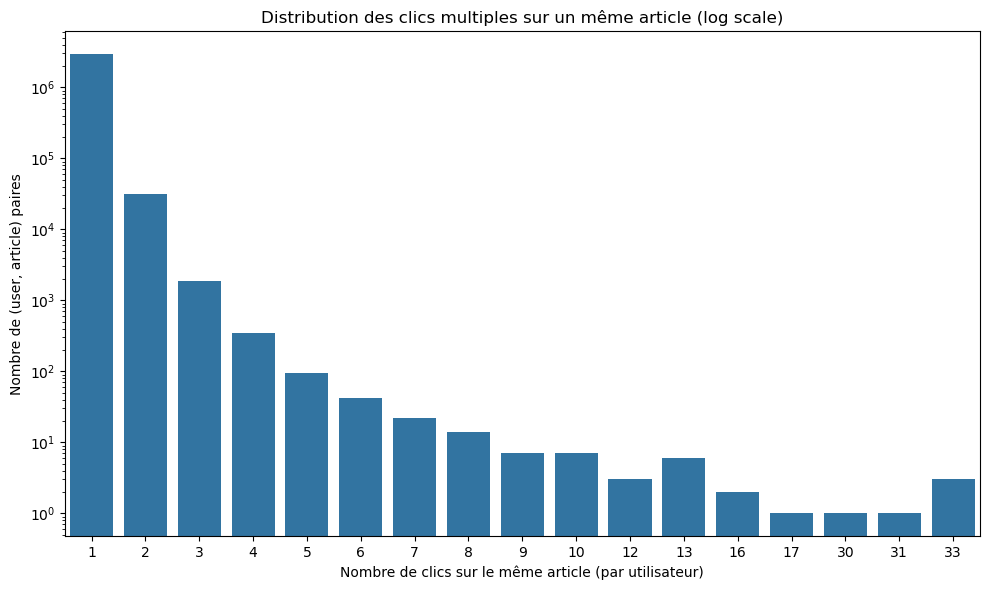

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 1 : Compter les clics par (utilisateur, article)
click_distribution = df_clicks.groupby(['user_id', 'click_article_id']).size().reset_index(name='click_count')

# Étape 2 : Compter combien de fois chaque valeur de `click_count` apparaît
click_count_distribution = click_distribution['click_count'].value_counts().sort_index()

# Étape 3 : Afficher la distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=click_count_distribution.index, y=click_count_distribution.values)
plt.yscale('log')  # optionnel : permet de mieux visualiser si forte disparité
plt.xlabel('Nombre de clics sur le même article (par utilisateur)')
plt.ylabel('Nombre de (user, article) paires')
plt.title('Distribution des clics multiples sur un même article (log scale)')
plt.tight_layout()
plt.show()


Il y a une décroissance exponentielle (avec un phénomène de long tail sur les valeurs les plus élevées). Une maojorité 1 à 2 clics.

# Recherche de comportements caractéristiques liés à la sélection d'articles

## Caractéristiques des sessions

### Nombre de sessions par utilisateur

In [20]:
# Compter le nombre de sessions distinctes par utilisateur
sessions_per_user = (
    df_clicks.groupby('user_id')['session_id']
    .nunique()
)

# Distribution de ces nombres
sessions_distribution = sessions_per_user.value_counts().sort_index()


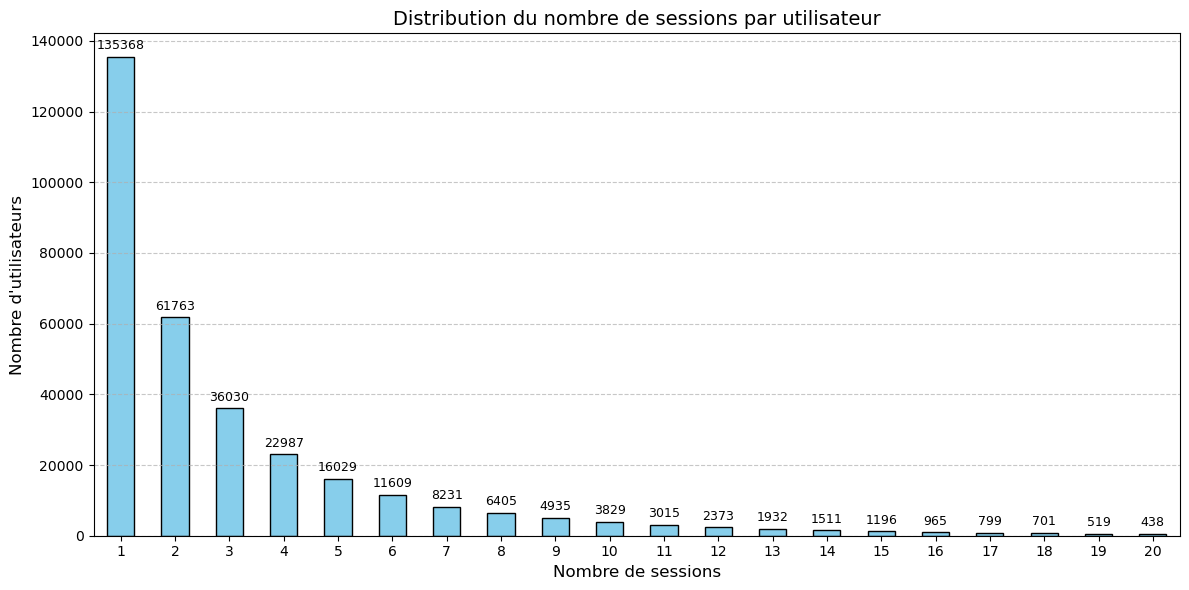

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Limiter l'affichage à un nombre raisonnable de sessions (ex: jusqu'à 20 sessions par utilisateur)
max_sessions_display = 20
filtered_distribution = sessions_distribution[sessions_distribution.index <= max_sessions_display]

# Barres avec annotations
ax = filtered_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution du nombre de sessions par utilisateur", fontsize=14)
plt.xlabel("Nombre de sessions", fontsize=12)
plt.ylabel("Nombre d'utilisateurs", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)

# Ajouter les valeurs sur les barres
for i, value in enumerate(filtered_distribution.values):
    ax.text(i, value + max(filtered_distribution.values) * 0.01, str(value), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


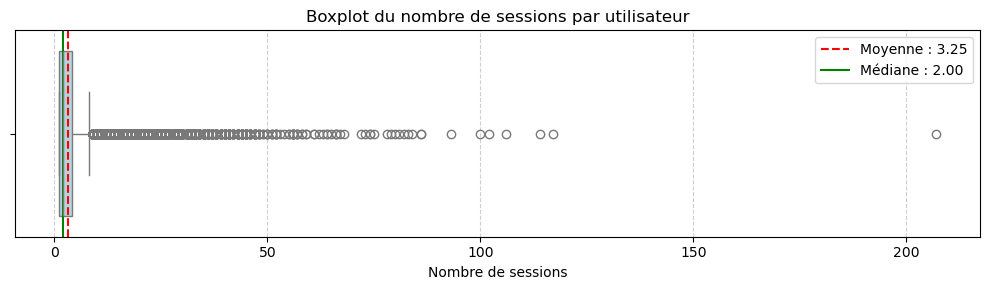

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcul des statistiques
mean_val = np.mean(sessions_per_user)
median_val = np.median(sessions_per_user)

# Création du boxplot
plt.figure(figsize=(10, 3))
sns.boxplot(x=sessions_per_user, color='lightblue')

# Ajout de la moyenne (ligne rouge) et de la médiane (ligne verte)
plt.axvline(mean_val, color='red', linestyle='--', label=f'Moyenne : {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='-', label=f'Médiane : {median_val:.2f}')

# Légendes et style
plt.title("Boxplot du nombre de sessions par utilisateur")
plt.xlabel("Nombre de sessions")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


Avec une médiane basse (2) et une moyenne plus élevée (3.25), on a une distribution asymétrique à droite (avec des "power users").<br>
🎯 Objectif :
Séparer les utilisateurs en deux groupes :<br>
Normaux : nombre de sessions ≤ Q3 <br>
Très consommateurs : nombre de sessions > Q3 <br><
Ajouter une colonne user_status dans df_clicks contenant normal ou tres_consommateur.

In [23]:
import numpy as np

# 1. Recalculer le nombre de sessions par utilisateur
sessions_per_user = df_clicks.groupby('user_id')['session_id'].nunique()

# 2. Calcul du Q3 (seuil au-dessus duquel on considère un "très consommateur")
q3 = sessions_per_user.quantile(0.75)

# 3. Création d’un DataFrame avec le statut par utilisateur
user_status = pd.DataFrame({
    'user_id': sessions_per_user.index,
    'nb_sessions': sessions_per_user.values,
    'user_status': np.where(sessions_per_user > q3, 'power_user', 'normal')
})

# 4. Fusionner cette info avec df_clicks
df_clicks = df_clicks.merge(user_status[['user_id', 'user_status']], on='user_id', how='left')
df_clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,user_status
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,normal
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,normal
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,power_user
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,power_user
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,normal


### Nombre d'articles cliqués par session (pas de groupement par utilisateur, toutes les sessions sont comptées)

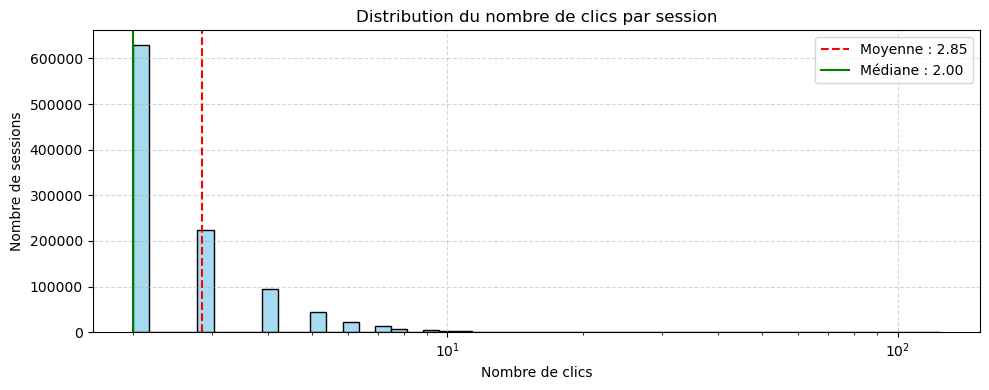

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Nombre de clics par session
clicks_per_session = df_clicks.groupby('session_id').size()

# 2. Calcul des statistiques
mean_clicks = clicks_per_session.mean()
median_clicks = clicks_per_session.median()

# 3. Affichage de la distribution
plt.figure(figsize=(10, 4))
sns.histplot(clicks_per_session, bins=50, kde=False, color='skyblue', log_scale=(True, False))

# Lignes de moyenne (rouge pointillée) et médiane (verte)
plt.axvline(mean_clicks, color='red', linestyle='--', label=f'Moyenne : {mean_clicks:.2f}')
plt.axvline(median_clicks, color='green', linestyle='-', label=f'Médiane : {median_clicks:.2f}')

# Titres, axes, légende
plt.title("Distribution du nombre de clics par session")
plt.xlabel("Nombre de clics")
plt.ylabel("Nombre de sessions")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


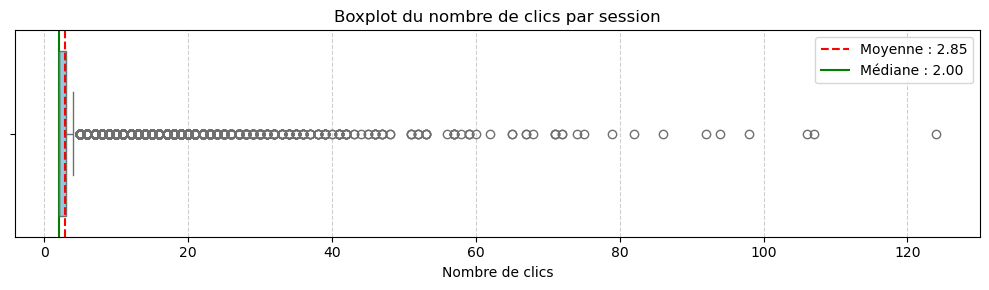

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Nombre de clics par session
clicks_per_session = df_clicks.groupby('session_id').size()

# Moyenne et médiane
mean_clicks = clicks_per_session.mean()
median_clicks = clicks_per_session.median()

# Affichage du boxplot
plt.figure(figsize=(10, 3))
sns.boxplot(x=clicks_per_session, color='skyblue', legend="full")

# Lignes pour la moyenne et la médiane
plt.axvline(mean_clicks, color='red', linestyle='--', label=f'Moyenne : {mean_clicks:.2f}')
plt.axvline(median_clicks, color='green', linestyle='-', label=f'Médiane : {median_clicks:.2f}')

# Titres et légende
plt.title("Boxplot du nombre de clics par session")
plt.xlabel("Nombre de clics")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


### Distribution temporelle (on utilise df_profiling)

In [ ]:
df_profiling['click_timestamp_dt'].dt.hour.value_counts().sort_index().plot(kind='bar')


In [ ]:
df_profiling['session_start_dt'].dt.hour.value_counts().sort_index().plot(kind='bar')

Les distributions ont des répartitions similaires, on va se concentrer sur les clics d'articles.

### Nombre de clics

In [ ]:
# Croisement jour/heure
import seaborn as sns
import matplotlib.pyplot as plt

# Créer la table croisée
heatmap_data = (
    df_profiling
    .groupby(['click_day', 'click_hour'])
    .size()
    .unstack(fill_value=0)
)

# Affichage heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt="d")
plt.title("Nombre de clics par jour de la semaine et heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Jour de la semaine (0 = Lundi)")
plt.tight_layout()
plt.show()


## Caractéristiques des utilisateurs
On va chercher des comportements qui peuvent caractériser l'intérêt des utilisateurs

### Durée des sessions

count    1.048594e+06
mean     7.870476e+02
std      5.667333e+03
min      0.000000e+00
25%      3.375725e+01
50%      9.599100e+01
75%      3.730305e+02
max      1.030097e+06
Name: delay_to_first_click_seconds, dtype: float64


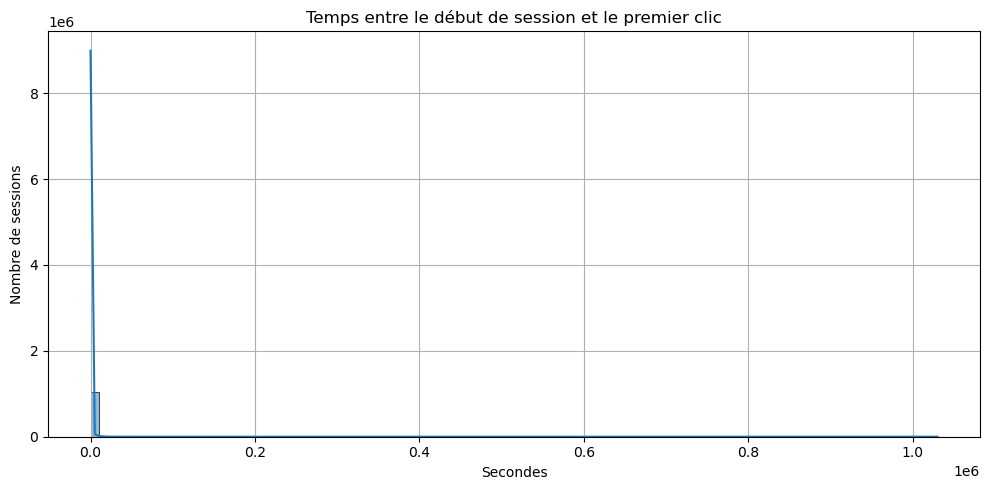

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Conversion des timestamps en datetime (si ce n’est pas déjà fait)
df_clicks["click_datetime"] = pd.to_datetime(df_clicks["click_timestamp"], unit="ms")
df_clicks["session_start_datetime"] = pd.to_datetime(df_clicks["session_start"], unit="ms")

# Identifier le premier clic par session
first_clicks = (
    df_clicks.sort_values("click_datetime")
    .groupby("session_id")
    .first()
)

# Calcul du délai entre le début de session et le premier clic
first_clicks["delay_to_first_click_seconds"] = (
    (first_clicks["click_datetime"] - first_clicks["session_start_datetime"]).dt.total_seconds()
)

# Affichage de statistiques descriptives
print(first_clicks["delay_to_first_click_seconds"].describe())

# Visualisation de la distribution
plt.figure(figsize=(10, 5))
sns.histplot(first_clicks["delay_to_first_click_seconds"], bins=100, kde=True)
plt.title("Temps entre le début de session et le premier clic")
plt.xlabel("Secondes")
plt.ylabel("Nombre de sessions")
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
import gc
gc.collect()

4162

count    1.008896e+06
mean     1.009558e+03
std      7.341976e+03
min      3.000000e+01
25%      8.656300e+01
50%      2.444365e+02
75%      7.798252e+02
max      2.078702e+06
Name: session_duration_seconds, dtype: float64


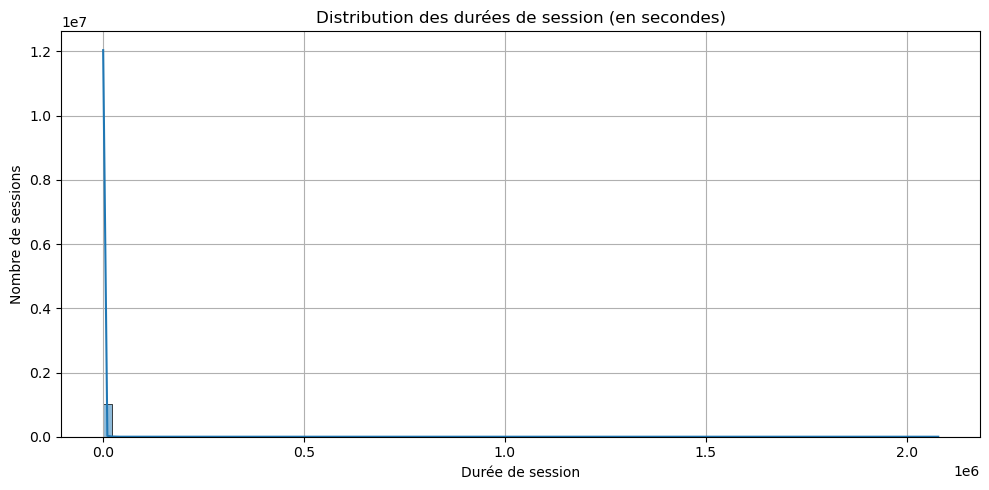

In [36]:
# 2. Filtrage des sessions raisonnables (< 1h entre session_start et 1er clic)
valid_session_ids = first_clicks[first_clicks["delay_to_first_click_seconds"] < 3600].index
df_valid_clicks = df_clicks[df_clicks["session_id"].isin(valid_session_ids)].copy()

# 3. Calcul de la durée de session = dernier clic - session_start
session_durations = (
    df_valid_clicks.groupby("session_id")
    .agg(session_start=("session_start_datetime", "first"),
         session_end=("click_datetime", "max"))
)
session_durations["session_duration_seconds"] = (
    (session_durations["session_end"] - session_durations["session_start"]).dt.total_seconds()
)

# 4. Stats descriptives
print(session_durations["session_duration_seconds"].describe())

# 5. Visualisation de la distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(session_durations["session_duration_seconds"], bins=100, kde=True)
plt.title("Distribution des durées de session (en secondes)")
plt.xlabel("Durée de session")
plt.ylabel("Nombre de sessions")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Filtrer les sessions d'une durée < 2h
filtered_sessions = session_durations[session_durations["session_duration_seconds"] < 7200].copy()

# 2. Nombre de clics par session
click_counts = df_valid_clicks.groupby("session_id").size().rename("nb_clicks")

# 3. Fusion durée + nombre de clics
df_corr = filtered_sessions.join(click_counts, how="inner")

# 4. Corrélation de Spearman (non paramétrique)
correlation = df_corr["session_duration_seconds"].corr(df_corr["nb_clicks"], method='spearman')
print(f"Corrélation de Spearman entre la durée de session et le nombre de clics : {correlation:.3f}")

# 5. Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_corr, x="session_duration_seconds", y="nb_clicks", alpha=0.3)
sns.regplot(data=df_corr, x="session_duration_seconds", y="nb_clicks", scatter=False, color="red")
plt.title("Durée de session vs Nombre de clics (sessions < 2h)")
plt.xlabel("Durée de session (secondes)")
plt.ylabel("Nombre de clics")
plt.grid(True)
plt.tight_layout()
plt.show()


La durée de session seule ne suffit pas à prédire l’engagement, mais elle est clairement informative.On poura éventuellement l'utiliser comme feature, mais aussi pour segmenter les comportements:<br>
- utilisateurs courts et peu actifs
- utilisateur courts cliquant beaucoup
- utilisateurs longs et actifs etc...<br>

Note: Pourquoi Spearman ? Mesure la relation monotone entre deux variables sans faire d’hypothèse sur leur distribution. C’est plus robuste si ta variable (durée ou clics) est asymétrique ou contient des outliers. Pearson fait l'hypothèse des distributions suivant une loi normale.

### Fréquence des clics

In [38]:
# Assure-toi d'avoir les colonnes datetime prêtes
df_clicks["click_datetime"] = pd.to_datetime(df_clicks["click_timestamp"], unit="ms")

In [ ]:
# Trier les clics dans chaque session
df_clicks_sorted = df_clicks.sort_values(["session_id", "click_datetime"]).copy()

# Calcul de la différence entre chaque clic successif
df_clicks_sorted["inter_click_delay"] = (
    df_clicks_sorted.groupby("session_id")["click_datetime"].diff().dt.total_seconds()
)

# Supprimer les NaN (1er clic de chaque session)
delays = df_clicks_sorted["inter_click_delay"].dropna()

# Statistiques descriptives
print(delays.describe())

# Visualisation de la distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(delays, bins=100, kde=True)
plt.title("Distribution du temps entre deux clics successifs (en secondes)")
plt.xlabel("Secondes")
plt.ylabel("Nombre de clics")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculs de la moyenne et de la médiane
mean_delay = delays.mean()
median_delay = delays.median()

# Affichage du boxplot
plt.figure(figsize=(10, 3))
sns.boxplot(x=delays, color='lightblue')

# Lignes moyenne (rouge) et médiane (verte)
plt.axvline(mean_delay, color='red', linestyle='--', label=f'Moyenne : {mean_delay:.2f} s')
plt.axvline(median_delay, color='green', linestyle='-', label=f'Médiane : {median_delay:.2f} s')

# Titre, axes, légende
plt.title("Boxplot du temps entre deux clics successifs")
plt.xlabel("Délai entre clics (secondes)")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Le maximum correspond à peu près à la durée pendant laquelle les clicks ont été suivis, ce qui fait penser à des problèmes de fermeture de session.

In [ ]:
delays_sorted = delays.sort_values(ascending=False)
print(delays_sorted.head(10))

In [ ]:
# 1. Suppression des valeurs extrêmes (> 10 min = 600s)
filtered_delays = delays[delays <= 600]

# 2. Nouvelles statistiques
print("Stats après filtrage (< 10 minutes) :")
print(filtered_delays.describe())

# 3. Visualisation propre
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(filtered_delays, bins=60, kde=True)
plt.title("Distribution du temps entre deux clics successifs (≤ 10 min)")
plt.xlabel("Secondes")
plt.ylabel("Nombre de clics")
plt.grid(True)
plt.tight_layout()
plt.show()


En enlevant les sessions non fermées on arrive à une valeur "standard" de lecture d'un article qui semble cohérente. Il va falloir soit filtrer soit trouver un moyen de ne pas prendre en compte ces durées entre clics qui sont certainement des erreurs de déconnexion.

### Appréciation des articles
Il n'y a pas de rating explicite, le fait de cliquer est une appréciation.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np

# --- Étape 1 : Clustering complet sur tous les embeddings ---
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)
kmeans_15 = KMeans(n_clusters=15, random_state=42, n_init='auto')
cluster_labels_15 = kmeans_15.fit_predict(embeddings_scaled)

# --- Étape 2 : Ajouter les clusters aux embeddings ---
df_clusters = pd.DataFrame({
    'article_id': embeddings.index,
    'cluster_15': cluster_labels_15
})

# --- Étape 3 : Popularité des articles ---
popularite_articles = df_clicks['click_article_id'].value_counts().reset_index()
popularite_articles.columns = ['article_id', 'nombre_de_clics']

# --- Étape 4 : Top 50 articles les plus populaires avec cluster ---
top_n = 50
top_articles = popularite_articles.head(top_n)
top_articles = top_articles.merge(df_clusters, on='article_id', how='left')

# --- Étape 5 : Couleurs pour les clusters ---
cmap = cm.get_cmap('tab20', 15)
top_articles['color'] = top_articles['cluster_15'].apply(lambda x: cmap(x))

# --- Étape 6 : Légende triée par nombre d'articles décroissant ---
cluster_counts = top_articles['cluster_15'].value_counts().sort_values(ascending=False)
legend_patches = [
    mpatches.Patch(color=cmap(cluster), label=f'Cluster {cluster} ({count})')
    for cluster, count in cluster_counts.items()
]

# --- Étape 7 : Tracé ---
plt.figure(figsize=(14, 6))
plt.bar(top_articles['article_id'].astype(str), top_articles['nombre_de_clics'], color=top_articles['color'])
plt.title(f'Top {top_n} articles les plus populaires (colorés par cluster)')
plt.xlabel("ID de l'article")
plt.ylabel("Nombre de clics")
plt.xticks(rotation=45)
plt.legend(handles=legend_patches, title="Clusters (dans top 50)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


On ne détecte pas de cluster notablement plus populaire que les autres.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Comptage des clics pour chaque article
popularite_articles = df_clicks['click_article_id'].value_counts()

plt.figure(figsize=(10, 6))
plt.hist(popularite_articles, bins=100, color='steelblue', edgecolor='black')
plt.yscale('log')  # Pour voir les articles peu cliqués
plt.xlabel("Nombre de clics par article")
plt.ylabel("Nombre d'articles (échelle log)")
plt.title("Distribution du nombre de clics par article")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Comptage des clics par article (déjà sans les articles à zéro clic)
popularite_articles = df_clicks['click_article_id'].value_counts()
data = popularite_articles.to_numpy()

# Calcul des statistiques
mean_val = np.mean(data)
median_val = np.median(data)
q3 = np.percentile(data, 75)

# Tracé du boxplot
plt.figure(figsize=(12, 2.5))
plt.boxplot(data, vert=False, patch_artist=True, showmeans=True,
            meanline=True, boxprops=dict(facecolor='lightblue'))

plt.title("Boxplot du nombre de clics par article (articles cliqués uniquement)")
plt.xlabel("Nombre de clics")

# Annoter les valeurs
plt.axvline(mean_val, color='red', linestyle='--', label=f'Moyenne = {mean_val:.1f}')
plt.axvline(median_val, color='orange', linestyle='-', label=f'Médiane = {median_val:.0f}')
plt.axvline(q3, color='green', linestyle='--', label=f"Q3 = {q3:.0f}")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


🔍 Lecture du boxplot :
Médiane = 1 :<br>
➤ Plus de 50 % des articles cliqués ne l'ont été qu'une seule fois → c’est ultra asymétrique !<br>
Q3 = 6 :<br>
➤ 75 % des articles cliqués ont reçu 6 clics ou moins.<br>
Moyenne = 64.9 :<br>
➤ Très au-dessus de la médiane, signe clair que quelques articles très populaires tirent la moyenne vers le haut.<br>
Présence de nombreux outliers :<br>
➤ Les cercles à droite (jusqu’à 36 000+) sont des articles exceptionnellement populaires – loi de puissance (long tail) typique des contenus.

📊 Interprétation stratégique :<br>
✔️ La majorité du contenu est peu consommé, ce qui est très courant dans les plateformes de contenu : quelques hits attirent tout le trafic.<br>
📈 Une stratégie de recommandation doit corriger cette inégalité :<br>
En valorisant les articles pertinents peu vus,<br>
En évitant de recommander uniquement les "blockbusters".

In [ ]:
#### Identification des articles star
import numpy as np
import pandas as pd

# Étape 1 : Popularité brute (clics par article)
popularite_articles = df_clicks['click_article_id'].value_counts()
data = popularite_articles.to_numpy()

# Étape 2 : Calcul des bornes des outliers supérieurs
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)
iqr = q3 - q1
seuil_star = q3 + 1.5 * iqr

# Étape 3 : Sélection des articles stars
articles_stars = popularite_articles[popularite_articles > seuil_star]
df_articles_stars = articles_stars.reset_index()
df_articles_stars.columns = ['article_id', 'nb_clics']

# Optionnel : tri décroissant
df_articles_stars = df_articles_stars.sort_values(by='nb_clics', ascending=False)

# Affichage
print(f"{len(df_articles_stars)} articles détectés comme 'stars' (clics > {int(seuil_star)})")
import pandas as pd
df_articles_stars.head(10)


In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Étape 1 : Nombre de clics par article
popularite_articles = df_clicks['click_article_id'].value_counts()
popularite_articles.name = 'nb_clics'

# Étape 2 : Détection des bornes "star"
q1 = np.percentile(popularite_articles.values, 25)
q3 = np.percentile(popularite_articles.values, 75)
iqr = q3 - q1
seuil_star = q3 + 1.5 * iqr

# Étape 3 : Merge avec df_articles, remplacer NaN par 0
df_articles = df_articles.copy()
df_articles = df_articles.merge(popularite_articles, how='left', left_on='article_id', right_index=True)
df_articles['nb_clics'] = df_articles['nb_clics'].fillna(0).astype(int)

# Étape 4 : Ajout du tag de popularité
def tag_popularite(nb_clics):
    if nb_clics == 0:
        return "jamais_cliqué"
    elif nb_clics > seuil_star:
        return "star"
    else:
        return "banal"

df_articles['popularite_tag'] = df_articles['nb_clics'].apply(tag_popularite)

# Étape 5 : Normalisation des nb_clics
scaler = MinMaxScaler()
df_articles['popularity_norm'] = scaler.fit_transform(df_articles[['nb_clics']])


In [41]:
# Sauvegarde dans un fichier CSV
df_articles.to_csv("./data/articles_with_popularity.csv", index=False)

## Variables de contexte (environment, device, os, country, region, referrer_type)

## Variation du contexte par session

In [ ]:
cols_to_check = [
    'click_environment', 'click_deviceGroup', 'click_os',
    'click_country', 'click_region', 'click_referrer_type'
]

# On calcule le nombre de valeurs uniques par colonne pour chaque session
context_change = df_clicks.groupby('session_id')[cols_to_check].nunique()

# Identifier pour chaque colonne combien de sessions ont plus d'une valeur (donc un changement)
changing_columns = (context_change > 1).sum().sort_values(ascending=False)

print("Nombre de sessions où la variable change :")
print(changing_columns)


referrer_type peut changer souvent car au cours de la navigation l'origine du click varie (depuis une recommandation , un carouseel, etc..), sinon les autres variantes sont globalement stables au cours d'une même session.

## Variations globales des variables de contexte

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Variables de contexte à analyser
context_cols = [
    'click_environment', 'click_deviceGroup', 'click_os',
    'click_country', 'click_region', 'click_referrer_type'
]

# Paramètres de mise en page
n_cols = 2
n_rows = int(np.ceil(len(context_cols) / n_cols))

# Création des subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

# Boucle sur chaque variable pour tracer les barplots
for idx, col in enumerate(context_cols):
    df_clicks[col].value_counts().sort_index().plot(kind='bar', ax=axes[idx], color='orange')
    axes[idx].set_title(f"Distribution de {col}")
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Fréquence")
    axes[idx].tick_params(axis='x', rotation=45)

# Masquer les axes inutilisés s'il y en a
for ax in axes[len(context_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## Variations des variables de contexte par rapport au nombre de clics

In [ ]:
# Ajouter session_size à récupérer aussi
cols = [
    'session_size',  # nombre de clics dans la session
    'click_environment', 'click_deviceGroup', 'click_os',
    'click_country', 'click_region', 'click_referrer_type'
]

# Prendre la première ligne de chaque session pour ces colonnes
df_session_summary = df_clicks.groupby('session_id')[cols].first().reset_index()

# Affichage
print(df_session_summary.head())


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Colonnes de contexte à analyser
context_cols = [
    'click_environment', 'click_deviceGroup', 'click_os',
    'click_country', 'click_region', 'click_referrer_type'
]

# Regrouper par session pour extraire une seule valeur par session
cols = ['session_size'] + context_cols
df_session_summary = df_clicks.groupby('session_id')[cols].first().reset_index()

# Calcul du 95e percentile pour ne pas écraser les plots à cause des outliers
ymax = df_session_summary['session_size'].quantile(0.95)

# Initialisation des résultats Spearman
spearman_results = {}

# Plot setup
n_cols = 2
n_rows = int(np.ceil(len(context_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(context_cols):
    # Corrélation de Spearman
    encoded_col = df_session_summary[col].astype('category').cat.codes
    corr, pval = spearmanr(encoded_col, df_session_summary['session_size'])
    spearman_results[col] = {'spearman_rho': corr, 'p_value': pval}
    
    # Violin plot avec limite Y
    sns.violinplot(data=df_session_summary, x=col, y='session_size', ax=axes[idx])
    axes[idx].set_title(f"{col} (ρ = {corr:.2f}, p = {pval:.2e})")
    axes[idx].set_ylim(0, ymax)
    axes[idx].tick_params(axis='x', rotation=45)

# Enlever les axes vides si pas besoin
for ax in axes[len(context_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Affichage des corrélations triées
pd.DataFrame(spearman_results).T.sort_values('spearman_rho', key=abs, ascending=False)


🧠 Interprétation :

Effet global très faible sur session_size ➜ aucune variable n’explique clairement l’engagement.

Les trois plus "informatives" sont click_deviceGroup, click_os et click_referrer_type mais avec des corrélations < 0.12 → pas exploitables directement pour prédire.

La taille du dataset rend les p-values très petites, mais ρ (rho) est ce qui compte ici, et ils sont faibles.

# Dataframe final pour modélisation
On va créer un dataframe structuré par interaction utilisateur-article enrichi avec:<br>
✅ infos utilisateur
✅ infos article (métadonnées + embedding réduit)
✅ timestamp (pour du tri ou du filtrage temporel)

In [42]:
# Etape 1: joindre les embeddings réduits et les articles
df_articles_full = df_articles.merge(embeddings_pca_df, left_on='article_id', right_index=True)
df_articles_full.shape

(364047, 51)

In [43]:
df_final = df_clicks.merge(df_articles_full, left_on='click_article_id', right_on='article_id')

In [48]:
df_final

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,31,32,33,34,35,36,37,38,39,40
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,...,-0.321467,0.910171,0.413014,-0.680843,-0.418416,0.526436,0.305626,-0.307790,-0.606359,-0.650552
1,20,1506825727279757,1506825727000,2,157541,1506836548634,4,1,17,1,...,-0.321467,0.910171,0.413014,-0.680843,-0.418416,0.526436,0.305626,-0.307790,-0.606359,-0.650552
2,44,1506826139185781,1506826139000,5,157541,1506857278141,4,1,17,1,...,-0.321467,0.910171,0.413014,-0.680843,-0.418416,0.526436,0.305626,-0.307790,-0.606359,-0.650552
3,45,1506826142324782,1506826142000,2,157541,1506827309970,4,1,17,1,...,-0.321467,0.910171,0.413014,-0.680843,-0.418416,0.526436,0.305626,-0.307790,-0.606359,-0.650552
4,76,1506826463226813,1506826463000,2,157541,1506828823469,4,3,2,1,...,-0.321467,0.910171,0.413014,-0.680843,-0.418416,0.526436,0.305626,-0.307790,-0.606359,-0.650552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,195186,1508210422411129,1508210422000,4,2221,1508210469562,4,3,2,1,...,-0.976228,-0.498757,-1.039714,0.702689,1.522792,2.781711,0.163197,0.055892,0.074216,-0.758865
2988177,75658,1508210696185183,1508210696000,4,271117,1508210951703,4,1,17,1,...,0.439297,0.000587,2.890927,2.992790,-0.374382,-1.499434,-0.511599,-0.384764,-1.549247,-1.203176
2988178,217129,1508210976336246,1508210976000,2,20204,1508210990810,4,3,2,1,...,1.841938,-0.111620,-1.259571,-1.696957,0.331692,2.844407,-1.142933,-1.769669,3.516544,-0.004632
2988179,217129,1508210976336246,1508210976000,2,70196,1508211020810,4,3,2,1,...,0.712064,0.271551,-0.250994,0.062602,-0.167102,3.326106,-0.831176,-0.342657,-0.467819,-0.496969


In [49]:
# sauvegarde format parquet (plus récent que pickle, lisible en dehors de python, compression automatique, conservation de types)
# Sauvegarde du DataFrame df_final au format Parquet
df_final.to_parquet("./data/df_final.parquet", index=False)

print("✅ Dataset sauvegardé au format Parquet.")

✅ Dataset sauvegardé au format Parquet.
